[Table of Contents](table_of_contents.ipynb)

# Topic 16.  Recursive Least Squares
Author: Seth Nielsen - sethmnielsen@gmail.com

Forgetting Factor Section: Brian Nelson - brnnelson4@gmail.com
    

##  Introduction

Least squares approximation is a method used to approximate the solution to an overdetermined system of equations. Linear least squares can be applied to a set of data to find a model that minimizes the sum of the squared errors between the data and their corresponding modeled values, thus creating a model of best fit. This method can further be applied to create a least-squares filter; a type of filter that, given a sequence of input data, uses least squares to find the coefficients that minimize the error between the filter's output and a desired sequence. 

The traditional form of a least squares filter is performed in *batch* form, where the minimizing solution is computed on an entire block of data after the data has been collected. This method of calculating a solution can be effective for applications suited to offline computation, but is not particularly useful for systems that require real-time or online parameter estimation for parameters that are unknown in advance or are changing. In this case, an adaptive filter is required. The recursive least squares filter modifies the least squares filter to be adaptive by continuously updating the estimated parameters (coefficients) as new data arrive. Thanks to the matrix inversion lemma (see the following derivation), the recursive least squares filter does not require the calculation of any matrix inverse, which can greatly lower computation requirements and precision errors when filtering large amounts of data. The computation can also have a "forgetting factor" added that allows the filter to follow a system with changing parameters.

## Explanation of the theory

We begin with the batch least squares filter with output $y_t$, minimizing coefficients $h_t$, and input signal $f_t$:

\begin{equation}
y_t = \sum_{i=0}^{m-1} h_{i}\ f_{t-i}
\end{equation}

The coefficients minimizing the least-squares error between filter output $y_t$ and a desired signal $d_t$ satisfy the normal equation (with data matrix $A$)

\begin{equation}
Rh = A^H d, \text{ where } R = A^H A = \sum_{i=1}^N q_{i}\ q_{i}^H \\
\text{with } q_i = \begin{bmatrix}f_{i}\\f_{i-1}\\...\\f_{i-m+1}\end{bmatrix}. \\
\end{equation}

Let

\begin{equation}
p = A^H d = \sum_{i=1}^N q_{i}d_i
\end{equation}

and thus the coefficients can be computed as

\begin{equation}
h = R^{-1}A^{H} = R^{-1}p
\end{equation}

The algorithm can now be made to be adaptive. From this point forward, all terms with subscript $_t$ are computing using the data only up to time $t$. 

Now define the Grammian matrix $R_t$ as

\begin{equation}
R_t = \sum_{i=1}^t q_{i}q_{i}^H
\end{equation}

and 

\begin{equation}
p_t = \sum_{i=1}^t q_{i}d_i = p_{t-1} + q_{t}d_{t} \\
\hat{h}_t = R_{t}^{-1}p_t \\
\end{equation}

where $\hat{h}_t$ is the estimated filter coefficients at time $t$.

The algorithm is now adaptive, but it still needs to be recursive ($R_{t}^{-1}$ is currently calculated at each time step). We can break $R_t$ up to be

\begin{align}
R_t &= \sum_{i=1}^{t-1}{q_i}{q_{i}^H} + {q_t}{q_{t}^H} \\
    &= R_{t-1} + q_{t}q_{t}^H
\end{align}

By the _matrix inversion lemma_ (eq. 4.32),

\begin{equation}
R_{t}^{-1} = R_{t-1}^{-1} - \frac{R_{t-1}^{-1}{q_t}\:{q_{t}^H}\:R_{t-1}^{-1}}{1 + {q_{t}^H}\:{R_{t-1}^{-1}}{q_t}}
\end{equation}

Let

\begin{equation}
P_t = R_{t}^{-1}
\end{equation}

and the _Kalman gain_

\begin{equation}
k_t = \frac{R_{t-1}^{-1}{q_t}}{1 + {q_{t}^H}{R_{t-1}^{-1}}{q_t}} = \frac{P_{t-1}^{-1}{q_t}}{1 + {q_{t}^H}{P_{t-1}^{-1}}{q_t}}.
\end{equation}

Then we arrive at
\begin{equation}
P_t = P_{t-1} - {k_t}\:{q_{t}^H}{P_{t-1}}. \quad \text{(eq. 4.38)}
\end{equation}

The coefficients for the filter, or the estimated parameters, are computed by

\begin{align}
\hat{h}_t &= P_t p_t = P_t (\ p_{t-1} + q_t\ d_t\ ) \\
&= P_t\ p_{t-1} + P_t\ q_t\ d_t \\
&= P_{t-1}\ p_{t-1} - k_t\ q_t^H\ P_{t-1}\ p_{t-1} + P_t\ q_t\ d_t \ \Leftarrow\ \text{using (eq. 4.38)} \\
&= \hat{h}_{t-1} - k_t\ q_t^H\ \hat{h}_{t-1} + k_t\ d_t \qquad \qquad \quad \Leftarrow\ k_t = P_t\ q_t \\
&= \hat{h}_{t-1} + k_t (\ d_t - q_t^H\ \hat{h}_{t-1}\ ).
\end{align}

The quantity multiplied by $k_t$ respresents the filter error

\begin{equation}
\varepsilon_t = d_t - q_t^H\ \hat{h}_{t-1},
\end{equation}

which allows us to write the update of the filter coefficients in the simple form of

\begin{equation}
\hat{h}_t = \hat{h}_{t-1} + k_t \varepsilon_t.
\end{equation}

### Initialization

To initialize the algorithm, the initial condition $P_0 = R_{0}^{-1}$ is needed. A slight perturbation of some small $\delta$ to the matrix $R_t$ gives the following:
\begin{align}
R_t &= \sum_{i=1}^t q_{i}q_{i}^H + \delta I \\
R_0 &= \delta I \\
P_0 &= \delta^{-1} I
\end{align}

Computing $P_0$ in this way allows the recursive algorithm to be free of calculating any matrix inverses.

The initial filter coefficients can be assumed to be zero, and thus $\hat{h}_0 = 0$.

## Adding a Forgetting Factor

The derivation above allows us to approximate a system with static coefficients--as the algorithm runs and more data is processed, it converges to a set of coefficients that minimize the error between the output of the system that it is generating, and the actual outputs. Well it is doing this, each input and output pair is given the same amount of weight. The first input and output will be weighted the same as the most recently obtained inputs and outputs. This works well if the coefficents of the system are known to be static, but if the system is changing, then we need a way for the system to adapt to place greater weight on new inputs and "forget" the old ones.

### Modifying the Equations shown above

To add a forgetting factor, we can look at the initial equation for how $R_t$ is calculated. As shown above, $R_t$ is the sum shown below.

\begin{align}
R_t &= \sum_{i=1}^{t-1}{q_i}{q_{i}^H} + {q_t}{q_{t}^H} \\
    &= R_{t-1} + q_{t}q_{t}^H
\end{align}

If we pick a number $\lambda$, where $0 < \lambda < 1$, and weight the previously computed values with this, the formula will place less weight on older inputs. This is shown below:

\begin{align}
R_t &= \lambda\sum_{i=1}^{t-1}{q_i}{q_{i}^H} + {q_t}{q_{t}^H} \\
    &= \lambda R_{t-1} + q_{t}q_{t}^H
\end{align}

Because this is redone at each step, the older an input gets, the less weight it will have in the current $R_t$ matrix. This ends up causing an exponentially decreasing focus on old inputs, that fits exactly what we are looking; as the system slowly changes with time, we still want to use the old inputs in the current computation, but we want more weight on more recent input/output pairs and less focus on inputs and outputs that happened far in the past.

If the derivation shown in the previous section to find the formulas for $P_t$, $k_t$, and $\hat{h}_t$ are followed using the formula for $R_t$ with a forgetting factor, then these formulas end up being as shown below.

\begin{align}
P_t = \lambda ^{-1}(P_{t - 1} - k_t q_t^H P_{t - 1})
\end{align}

\begin{align}
k_t = \frac{P_{t-1}q_t}{\lambda + q_{t}^H P_{t-1}}
\end{align}

\begin{align}
\hat{h}_t = \lambda^{-1}\hat{h}_{t-1}+k_t(y_t - \lambda^{-1}q_t\hat{h}_{t-1})
\end{align}

$\lambda$ is generally chosen to be between $0.98$ and $1$. The higher the value of $\lambda$ is chosen, the more the old input/output pairs will affect the current estimates of the system coefficients.


## Simple Numerical Examples

We can start by estimating the parameters of a simple system using a recursive least squares filter. Let's choose a system with impulse response $h = [\ 5,6,7,8,9\ ]$ . The following filter written in Python will give normally-distributed random values $f_t$ as inputs and attempt to match the system's true output $d_t$ by computing the error $\varepsilon_t = d_t - y_t$ , where $y_t$ is the filtered output evaluated as $y_t = q_{t}^H \ \hat{h}_t$, and $\hat{h}_t$ is the vector of $m$ estimated parameters that is updated by computing $\hat{h}_t = \hat{h}_{t-1} + k_t \varepsilon_t$ at each timestep. The vector $q_t$ is simply the $m$ most recent input values taken from the signal $f_t$. 

The variable $m$ can be set at the beginning of the script to choose how many filter coefficients will be used, thus defining the size of $\hat{h}$ and $q_t$.

In [13]:
import numpy as np
np.set_printoptions(precision=4)


m = 5      # number of parameters
n = 10000   # iterations

h = np.array([5,6,7,8,9])  # impulse response
hhat = np.zeros(m)         # initial estimated parameters
f = np.random.randn(n)     # normally-distributed random input
fn = np.hstack(([0,0,0,0],f))  # convenience array used to shift through input (f)
q = np.zeros(m)  # input data for one time step
delta = .0001
P = 1/delta * np.eye(m)  # initialize P[0] without calculating inverse of R[0]


for i in range(n):
    d = fn[i:i+5] @ h  # true output
    q = fn[i:i+m]      # q update

    k = P @ q / (1 + q.T @ P @ q)  # kalman gain vector
    y = q @ hhat  # filter output
    e = d - y     # error
    
    hhat = hhat + k * e  # update of estimated parameters
    P = P - k * q @ P    # P update

print('hhat:',hhat)

hhat: [5. 6. 7. 8. 9.]


## Engineering Application - Mass-Spring-Damper System Indentification

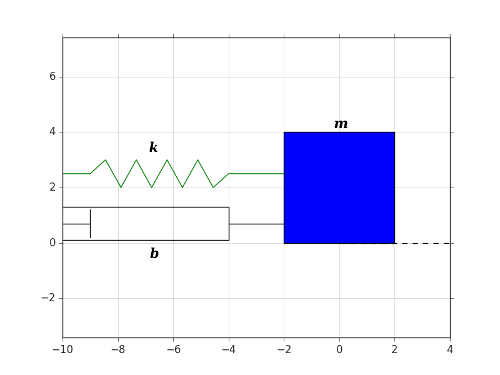


In this example, the following Python code will attempt to find the optimal filter coefficients to match the output of a mass-spring-damper system given a horizontal force $F$ as input. The force varies over time sinusoidally. The output of the system is the position of the mass. The output is calculated using the Runge-Kutta RK4 algorithm to integrate the first order ODE 
\begin{equation}
m\ddot{x} + b\dot{x} + kx = F.
\end{equation}

and propagating the dynamics at each time step $T_s$.

Gaussian noise has been added to the output as well as some uncertainty in the system's physical parameters (mass $m$, spring-constant $k$, and damping coefficient $b$). 

In [2]:
class msdParam:
    
    def __init__(self):
        # Physical parameters
        self.m = 5.;  # kg
        self.k = 3.;  # N/m
        self.b = 0.5; # N m s

        # Simulation Parameters
        self.t_start = 0.0;  # Start time of simulation
        self.Ts = 0.1;       # sample time for simulation

        # Initial Conditions
        self.z0 = 0.0;
        self.zd0 = 0.0;

In [3]:
import random
P_ = msdParam()


class msdDynamics:
    '''
        Model the physical system
    '''

    def __init__(self):
        # Initial state conditions
        self.state = np.matrix([[P_.z0],    # initial position
                                [P_.zd0]])  # initial velocity

        alpha = 0.02  # Uncertainty parameter
        self.m = P_.m * (1+2*alpha*np.random.rand()-alpha)  # Mass of the msd, kg
        self.k = P_.k * (1+2*alpha*np.random.rand()-alpha)  # Spring constant, N/m
        self.b = P_.b * (1+2*alpha*np.random.rand()-alpha)  # Damping coefficient, Ns
        self.Ts = P_.Ts  # sample rate at which the dynamics are propagated

    def propagateDynamics(self, u):
        '''
            Integrate the differential equations defining dynamics
            P.Ts is the time step between function calls.
            u contains the system input(s).
        '''
        # Integrate ODE using Runge-Kutta RK4 algorithm
        k1 = self.derivatives(self.state, u)
        k2 = self.derivatives(self.state + self.Ts/2*k1, u)
        k3 = self.derivatives(self.state + self.Ts/2*k2, u)
        k4 = self.derivatives(self.state + self.Ts*k3, u)
        self.state += self.Ts/6 * (k1 + 2*k2 + 2*k3 + k4)

    def derivatives(self, state, u):
        '''
            Return xdot = f(x,u), the derivatives of the continuous states, as a matrix
        '''
        # re-label states and inputs for readability
        z = state.item(0)
        zd = state.item(1)
        F = u[0]

        # Equations of motion
        zdd = (F - self.b*zd - self.k*z)/self.m
        # build xdot and return
        xdot = np.matrix([[zd], [zdd]])
        return xdot

    def outputs(self):
        '''
            Returns the measured outputs as a list
            [z] with added Gaussian noise
        '''
        # re-label states for readability
        z = self.state.item(0)
        # add Gaussian noise to outputs
        z_m = z + random.gauss(0, 0.001)
        # return measured outputs
        return [z_m]

    def states(self):
        '''
            Returns all current states as a list
        '''
        return self.state.T.tolist()


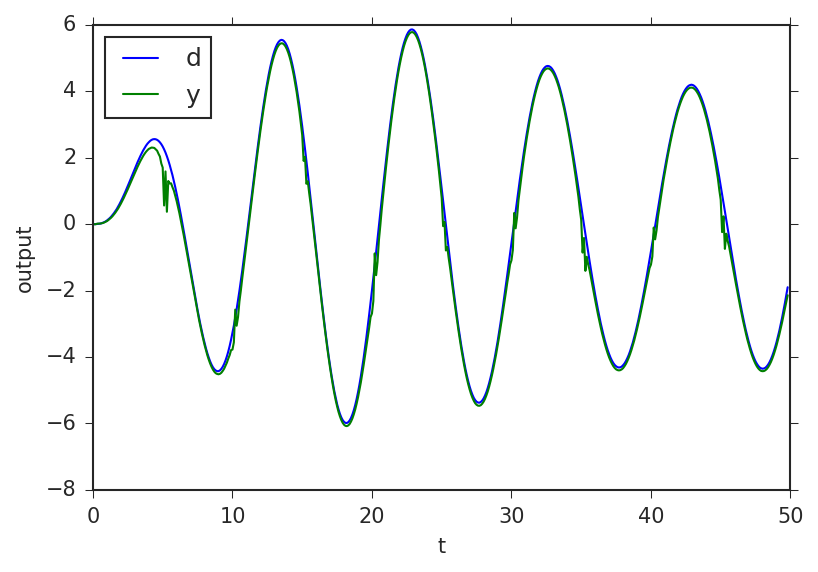


hhat: [-2.8695 -0.4514  3.3125]


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

msd = msdDynamics()
param = msdParam()

# Input signal (sine wave)
amplitude=5
frequency=0.1

m = 3     # number of parameters (k, b, m)
time = 50 # secs
n = int(time//param.Ts)  # iterations

hhat = np.zeros(m)         # initial estimated parameters

q = np.zeros(m)
delta = .00001
P = 1/delta * np.eye(m)  # initial P

# Arrays for plotting
d_arr = np.zeros(n)
y_arr = np.zeros(n)
t_arr = np.zeros(n)

t = param.t_start  # time starts at t_start
for i in range(n):
    u = [amplitude*np.sin(2*np.pi*frequency*t)]  # input (force on mass)

    msd.propagateDynamics(u)
    d = msd.outputs()[0]          # system output (position of mass)
    q = np.hstack((u[0],q[:-1]))  # q update

    k = P @ q / (1 + q.T @ P @ q)  # kalman gain vector
    y = q @ hhat  # filter output
    e = d - y     # error

    hhat = hhat + k * e  # update of estimated parameters
    P = P - k * q @ P    # P update

    # Saving values for plot
    d_arr[i] = d
    y_arr[i] = y
    t_arr[i] = t

    t = t + param.Ts  # advance time by Ts


fig = plt.figure(dpi=150)
plt.plot(t_arr, d_arr, label='d')
plt.plot(t_arr, y_arr, label='y')
plt.xlabel('t')
plt.ylabel('output')
plt.legend(loc='upper left')

plt.show()

print('\nhhat:',hhat)


The filter's output $y$ very quickly converges to match the system's output $d$ with only minor deviations thereafter. Note that the filter coefficents $\hat{h}$ differ from the system's parameters, yet the filter output is still very close to that of the system.

## Homework Problem

### Background
Recursive Least Squares is a powerful tool that can be used to model an unknown system based solely on the inputs and outputs of that system. One application of this is in filtering audio. In this problem you will be taking an input audio clip that is all of the notes of the song “Mary Had a Little Lamb” being played on the piano at the same time for the length of the song, and an output that is an audio clip of the whole song “Mary Had a Little Lamb”. Given this input and output data, build a system that filters the input clip to sound like the output clip. 


### Other information
There is some starter code shown below. The input audio clip is called mary_had_a_little_lamb_in.wav, and the output is mary_had_a_little_lamb_out.wav.
The starter code given will read in the .wav files, set up a few helper arrays and variables to make things a little easier, and will write the output to a .wav file called generated_out.wav.

HINT: The filtering will need to be adaptive. This is because the audio output changes over time while the input to the system stays consistent. This means that the recursive least squares algorithm will need to include a forgetting factor to place greater weight on newer input/output pairs.

### Input and output files:
[mary_had_a_little_lamb_in.wav](files/mary_had_a_little_lamb_in.wav)

[mary_had_a_little_lamb_out.wav](files/mary_had_a_little_lamb_out.wav)


In [ ]:
import numpy as np
import scipy.io.wavfile as wav

# get the input and output files
[rateIn, inWav] = wav.read("mary_had_a_little_lamb_in.wav", 'r')
[rateOut, expectedOutWav] = wav.read("mary_had_a_little_lamb_out.wav", 'r')

# number of taps in the filter.
numberOfParameters = 5

n = expectedOutWav.size   # length of the expected output

# convenience array used to shift through input. The beginning is padded with zeros,
# and the end is also padded with zeros.
fn = np.hstack((np.zeros(numberOfParameters - 1),
                inWav, np.zeros(numberOfParameters - 1)))

# impulse response of system we are generating
h = np.zeros(numberOfParameters)

# preallocate the output that we will be generating
generated_output = np.zeros(n)

'''
WRITE YOUR CODE HERE.

- fn is an array of inputs that has already been zero padded
- h is the array for the system coefficients that your code will be using to 
  approximate the system
- generated_output is an array that you should write each output of your system to.
  This will be saved to a .wav file that you can listen to once the system is done
  processing.

You will need to:
1. set up P
2. loop through the inputs and outputs to compute P, k, h, and the generated_output
   at each time step. Save your guessed outputs to the generated_output array for
   it to be written to a wave file at the end of the processing
'''

# write the output to a wav file.
generated_output = generated_output.astype(np.int16)
wav.write("generated_out.wav", rateOut, generated_output)
